In [158]:
import pandas as pd

pd.set_option('display.max_columns',None)

In [159]:
df = pd.read_excel('Telco_customer_churn_adapted_v2.xlsx')

In [160]:
df.drop(columns=['Customer ID','Longitude','Latitude'],inplace=True)

In [161]:
df.head(3)

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,CLTV (Predicted Thou. IDR)
0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,4210.7
1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,3511.3
2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,6983.6


# Prepocessing

Missing values

In [162]:
df.isna().sum()

Tenure Months                   0
Location                        0
Device Class                    0
Games Product                   0
Music Product                   0
Education Product               0
Call Center                     0
Video Product                   0
Use MyApp                       0
Payment Method                  0
Monthly Purchase (Thou. IDR)    0
Churn Label                     0
CLTV (Predicted Thou. IDR)      0
dtype: int64

Duplicate

In [163]:
print(f'Data Asli: {df.shape}')
print(f"Cek duplikat: {df.drop_duplicates(subset=df.drop(columns=['Churn Label']).columns, keep='first').shape}")

Data Asli: (7043, 13)
Cek duplikat: (7043, 13)


# Encoding

In [164]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Train Test Split

In [167]:
from sklearn.model_selection import train_test_split

# Bagi data menjadi set pelatihan dan sisanya
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Churn Label']), df['Churn Label'], test_size=0.2, random_state=42, stratify=df['Churn Label'])

# Tampilkan ukuran set pelatihan, validasi, dan uji
print("Jumlah sampel dalam set pelatihan: ", len(X_train))
print("Jumlah sampel dalam set uji: ", len(X_test))


Jumlah sampel dalam set pelatihan:  5634
Jumlah sampel dalam set uji:  1409


# Scaling Numeric

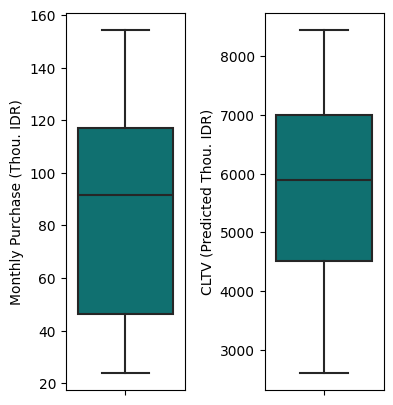

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric = ['Monthly Purchase (Thou. IDR)','CLTV (Predicted Thou. IDR)']

plt.figure(figsize=(10,20))
# plotting
for i in range(0, len(numeric)):
    plt.subplot(5, 5, i+1)
    sns.boxplot(y=X_train[numeric[i]],color='teal', orient='v')
    plt.tight_layout()

In [169]:
from sklearn.preprocessing import PowerTransformer

scaler_power = PowerTransformer(method='yeo-johnson')

X_train[numeric] = scaler_power.fit_transform(X_train[numeric])
X_test[numeric] = scaler_power.fit_transform(X_test[numeric])

# Outlier Tree Analysis

In [170]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=1500, random_state=42,contamination=.075)
clf.fit(X_train)

IsolationForest(contamination=0.075, max_samples=1500, random_state=42)

In [171]:
import numpy as np
# Predictions on the test set
predictions = clf.predict(X_train)

# Identify indices of outliers
outlier_indices = np.where(predictions == -1)[0]

# Impute outliers with the median value
for column in X_train.columns:
    median_value = X_train[column].median()
    X_train.iloc[outlier_indices, X_train.columns.get_loc(column)] = median_value

# Balancing

In [172]:
print(f'Perbandingan nilai Y: \n{y_train.value_counts()}')

Perbandingan nilai Y: 
0    4139
1    1495
Name: Churn Label, dtype: int64


In [173]:
# Inisialisasi SMOTE
from imblearn.over_sampling import SMOTEN

smote = SMOTEN(random_state=42,k_neighbors=3)

# Resampling pada train set
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [179]:
import plotly.express as px

# Data sebelum balancing
fig = px.bar(x=y_train.value_counts().index, y=y_train.value_counts().values, 
             labels={'x': 'Class', 'y': 'Jumlah'},
             title='Sebelum Balancing')
fig.update_layout(barmode='group', showlegend=False)

# Data setelah balancing
fig2 = px.bar(x=y_train_over.value_counts().index, y=y_train_over.value_counts().values,
              labels={'x': 'Class', 'y': 'Jumlah'},
              title='Sesudah Balancing (SMOTEN)')
fig2.update_layout(barmode='group', showlegend=False)

# Tampilkan plot
fig.show()
fig2.show()


# Feature Selection

In [96]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier


# Pilih model yang ingin digunakan (dalam contoh ini, kita gunakan RandomForestClassifier)
model = RandomForestClassifier(n_jobs=-1,random_state=42)

# Inisialisasi RFE dengan model dan jumlah fitur yang ingin dihasilkan
rfe = RFE(model,n_features_to_select=10)

# Fit RFE pada data pelatihan
fit = rfe.fit(X_train, y_train)

# Membuat DataFrame dari hasil RFE
result_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': fit.ranking_,
    'Selected': fit.support_
})

# Menyortir DataFrame berdasarkan nilai Ranking
result_df_sorted = result_df.sort_values(by='Ranking')
result_df_sorted


,Feature,Ranking,Selected
0,Tenure Months,1,True
1,Location,1,True
2,Device Class,1,True
3,Games Product,1,True
4,Music Product,1,True
5,Education Product,1,True
6,Call Center,1,True
9,Payment Method,1,True
10,Monthly Purchase (Thou. IDR),1,True
11,CLTV (Predicted Thou. IDR),1,True


In [97]:
# Menghapus variabel yang tidak dipilih oleh RFE dari X_train
X_train_over = rfe.transform(X_train_over)

# Menghapus variabel yang tidak dipilih oleh RFE dari X_test
X_test = rfe.transform(X_test)


# Model

In [98]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Predictions on the test set
    predictions = classifier.predict(X_test)
    
    # Print classification report
    clr = classification_report(y_test, predictions)
    print(clr)
    
    return clr  # You may choose to return the classification report if needed

# Define class weights
class_weights = 'balanced'

# Create instances of classifiers
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=class_weights)
et_classifier = ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight=class_weights)
gb_classifier = GradientBoostingClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)
cat_classifier = CatBoostClassifier(random_state=42, verbose=0)

# List of classifiers
classifiers = [
    ("Decision Tree", dt_classifier),
    ("Random Forest", rf_classifier),
    ("ExtraTrees", et_classifier),
    ("Gradient Boosting", gb_classifier),
    ("XGBoost", xgb_classifier),
    ("CatBoost", cat_classifier)
]

# Evaluate each classifier
for classifier_name, classifier in classifiers:
    print(f"Evaluating {classifier_name}:")
    evaluate_classifier(classifier, X_train_over, y_train_over, X_test, y_test)
    print("\n")


Evaluating Decision Tree:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1035
           1       0.47      0.53      0.50       374

    accuracy                           0.71      1409
   macro avg       0.64      0.66      0.65      1409
weighted avg       0.73      0.71      0.72      1409



Evaluating Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.59      0.57      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



Evaluating ExtraTrees:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1035
           1       0.53      0.53      0.53       374

    accuracy                           0.75      1409
   macro avg       0.68      0.68      0.68      

# Optimasi Model

In [99]:
from sklearn.model_selection import RandomizedSearchCV

def perform_random_search(classifier, param_dist, X_train, y_train):
    random_search = RandomizedSearchCV(classifier, param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    best_model = random_search.best_estimator_
    predictions = best_model.predict(X_test)
    
    clr = classification_report(le.inverse_transform(y_test), le.inverse_transform(predictions))
    
    print(f"Best Parameters for {classifier.__class__.__name__}:")
    print(f'{random_search.best_params_}\n')
    print(f"Best Mean CV Score for {classifier.__class__.__name__}: {random_search.best_score_}")
    
    cv_results = random_search.cv_results_
    for i, params in enumerate(cv_results['params']):
        if params == random_search.best_params_:
            print(f"CV Scores for Best Parameters of {classifier.__class__.__name__} (5 Folds):")
            for fold in range(5):
                fold_key = f"split{fold}_test_score"
                fold_scores = cv_results[fold_key][i]
                print(f"Fold {fold + 1}: {fold_scores:.4f}\n")
    
    return best_model, clr

In [100]:
# Decision Tree Classifier
dt_param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(range(10, 101, 3)),
    'min_samples_split': list(range(2, 101)),
    'min_samples_leaf': list(range(1, 101))
}

best_dt_model, dt_clr = perform_random_search(DecisionTreeClassifier(random_state=42), dt_param_dist, X_train_over, y_train_over)

# Random Forest Classifier
rf_param_dist = {
    'n_estimators': list(range(100, 2000, 10)),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(10, 201, 3)),
    'min_samples_split': list(range(2, 101)),
    'min_samples_leaf': list(range(1, 101))
}

best_rf_model, rf_clr = perform_random_search(RandomForestClassifier(random_state=42, n_jobs=-1), rf_param_dist, X_train_over, y_train_over)

# ExtraTrees Classifier
et_param_dist = {
    'n_estimators': list(range(100, 2000, 10)),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(10, 201, 3)),
    'min_samples_split': list(range(2, 101)),
    'min_samples_leaf': list(range(1, 101))
}

best_et_model, et_clr = perform_random_search(ExtraTreesClassifier(random_state=42, n_jobs=-1), et_param_dist, X_train_over, y_train_over)

# Gradient Boosting Classifier
gb_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': list(range(3, 11)),
    'min_samples_split': list(range(2, 21)),
    'min_samples_leaf': list(range(1, 11))
}

best_gb_model, gb_clr = perform_random_search(GradientBoostingClassifier(random_state=42), gb_param_dist, X_train_over, y_train_over)

# XGBoost Classifier
xgb_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': list(range(3, 11)),
    'min_child_weight': list(range(1, 8)),
    'gamma': [i/10.0 for i in range(0, 5)],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

best_xgb_model, xgb_clr = perform_random_search(XGBClassifier(random_state=42, n_jobs=-1), xgb_param_dist, X_train_over, y_train_over)

# CatBoost Classifier
cat_param_dist = {
    'iterations': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'depth': list(range(3, 10)),
    'l2_leaf_reg': list(range(1, 10))
}

best_cat_model, cat_clr = perform_random_search(CatBoostClassifier(random_state=42, verbose=0), cat_param_dist, X_train_over, y_train_over)

Best Parameters for DecisionTreeClassifier:
{'splitter': 'best', 'min_samples_split': 76, 'min_samples_leaf': 38, 'max_depth': 82, 'criterion': 'entropy'}

Best Mean CV Score for DecisionTreeClassifier: 0.7845002700059839
CV Scores for Best Parameters of DecisionTreeClassifier (5 Folds):
Fold 1: 0.6938

Fold 2: 0.7325

Fold 3: 0.8339

Fold 4: 0.8344

Fold 5: 0.8278

Best Parameters for RandomForestClassifier:
{'n_estimators': 1510, 'min_samples_split': 66, 'min_samples_leaf': 3, 'max_depth': 64, 'criterion': 'gini'}

Best Mean CV Score for RandomForestClassifier: 0.7975450618094779
CV Scores for Best Parameters of RandomForestClassifier (5 Folds):
Fold 1: 0.7162

Fold 2: 0.7500

Fold 3: 0.8484

Fold 4: 0.8489

Fold 5: 0.8242

Best Parameters for ExtraTreesClassifier:
{'n_estimators': 1510, 'min_samples_split': 66, 'min_samples_leaf': 3, 'max_depth': 64, 'criterion': 'gini'}

Best Mean CV Score for ExtraTreesClassifier: 0.79319387889137
CV Scores for Best Parameters of ExtraTreesClassif

# Evaluasi Model

In [101]:
import plotly.figure_factory as ff
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Include your classifier instances and data splitting as before

classifiers = [
    ("Decision Tree", best_dt_model),
    ("Random Forest", best_rf_model),
    ("ExtraTrees", best_et_model),
    ("Gradient Boosting", best_gb_model),
    ("XGBoost", best_xgb_model),
    ("CatBoost", best_cat_model)
]

for classifier_name, classifier in classifiers:
    # Confusion Matrix
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred))

    fig = ff.create_annotated_heatmap(
        z=cm,
        x=["{}".format(label) for label in le.classes_],
        y=["{}".format(label) for label in le.classes_],
        colorscale="Viridis",
    )

    fig.update_layout(
        title="Confusion Matrix for {}".format(classifier_name),
        xaxis_title="Predicted Churn",
        yaxis_title="Actual Churn",
    )

    fig.show()

In [102]:
# Menampilkan classification reports untuk model terbaik
print("DTC:")
print(dt_clr)
print("RFC:")
print(rf_clr)
print("ETC:")
print(et_clr)
print("GBC:")
print(gb_clr)
print("XGBC:")
print(xgb_clr)
print("CatBoost:")
print(cat_clr)


DTC:
              precision    recall  f1-score   support

          No       0.86      0.79      0.82      1035
         Yes       0.53      0.64      0.58       374

    accuracy                           0.75      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.77      0.75      0.76      1409

RFC:
              precision    recall  f1-score   support

          No       0.87      0.82      0.85      1035
         Yes       0.58      0.66      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.79      1409

ETC:
              precision    recall  f1-score   support

          No       0.87      0.81      0.84      1035
         Yes       0.55      0.66      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409

GBC:

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import plotly.express as px
import pandas as pd

# Inisialisasi data untuk visualisasi
data = {
    'Classifier': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': []
}

# Loop through classifiers and collect evaluation metrics
for classifier_name, classifier in classifiers:
    predictions = classifier.predict(X_test)  # Assuming you have X_test
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    data['Classifier'].append(classifier_name)
    data['Accuracy'].append(accuracy)
    data['Precision'].append(precision)
    data['Recall'].append(recall)
    data['F1-score'].append(f1)

# Create a DataFrame from the collected data
score = pd.DataFrame(data)

# Sort DataFrame by F1-score in descending order
df_sorted = score.sort_values(by=['F1-score','Recall'], ascending=False)

# Create a bar chart using Plotly Express
fig = px.bar(
    df_sorted,
    x='Classifier',
    y=['Accuracy', 'Precision', 'Recall', 'F1-score'],
    title='Model Evaluation Metrics (Sorted by F1-score & Recall)',
    labels={'value': 'Score', 'variable': 'Metric'},
    barmode='group',
)

# Show the plot
fig.show()


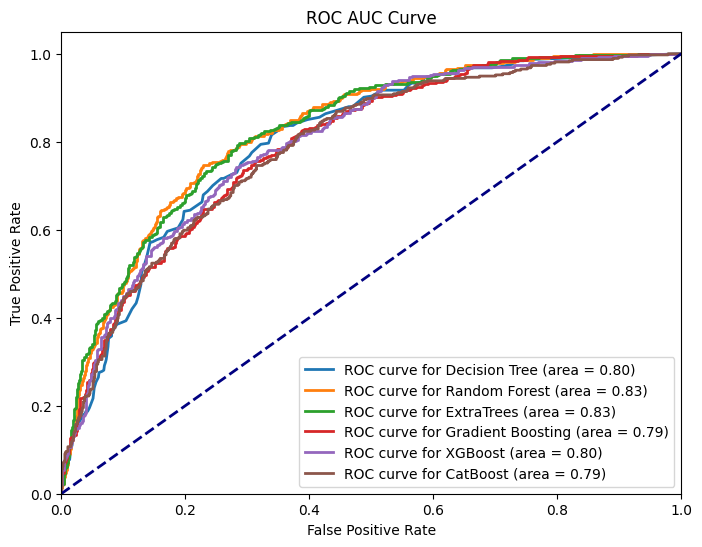

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Include your classifier instances and data splitting as before

classifiers = [
    ("Decision Tree", best_dt_model),
    ("Random Forest", best_rf_model),
    ("ExtraTrees", best_et_model),
    ("Gradient Boosting", best_gb_model),
    ("XGBoost", best_xgb_model),
    ("CatBoost", best_cat_model)
]

plt.figure(figsize=(8, 6))

for classifier_name, classifier in classifiers:
    # ROC AUC
    y_score = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='ROC curve for {} (area = {:.2f})'.format(classifier_name, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()
